In [38]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import json

In [39]:
DATA_DIR = os.path.join("Dataset3", "data")
CLASS_NAMES = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]
IMAGE_SIZE = (28, 28)
BATCH_SIZE = 32
SEED = 123
MODEL_PATH = 'HCRModel.keras'
EPOCHS = 100
HISTORY_PATH = 'training_history.json'

In [40]:
def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='categorical',
        class_names=[str(i) for i in range(62)],
        validation_split=0.2,
        subset='training',
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='categorical',
        class_names=[str(i) for i in range(62)],
        validation_split=0.2,
        subset='validation',
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )

    norm_layer = layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (norm_layer(x), y))

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    print("Dataset Loaded")
    return train_ds, val_ds

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        # Kurangi learning rate sebesar 10% setiap setelah epoch ke-10
        return lr * tf.math.exp(-0.1)

In [ ]:
class HCR:
    def __init__(self, image_size, model_path=MODEL_PATH, epochs=EPOCHS, history_path=HISTORY_PATH):
        self.image_size = image_size
        self.model_path = model_path
        self.epochs = epochs
        self.history = None
        self.history_path = history_path

        self.data_augmentation = tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
        ])

    def build_model(self, num_classes):
        regularizer = tf.keras.regularizers.l2(0.001)
        model = models.Sequential([
            layers.Input((self.image_size[0], self.image_size[1], 3)),
            layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizer),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu', kernel_regularizer=regularizer),
            layers.Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        model.summary()
        return model
    
    def train(self, model, train_ds, val_ds):
        print(f"Epochs : {self.epochs} epoch...")
        model_checkpoint_callback = callbacks.ModelCheckpoint(
            filepath=self.model_path,
            save_best_only=True,             
            monitor='val_accuracy',           
            mode='max',                      
            verbose=1                         
        )

        early_stopping_callback = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        lr_scheduler_callback = callbacks.LearningRateScheduler(scheduler)
        
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=self.epochs,
            callbacks=[model_checkpoint_callback, early_stopping_callback, lr_scheduler_callback]
        )
        self.history = history.history

        print("Training Completed")
        return self.history
    
    def plot_history(self):
        if self.history is None:
            print("Error: not trained")
            return
        hist = self.history
        epochs = range(1, len(hist['loss']) + 1)
        
        # --- Plot Loss ---
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hist['loss'], 'r', label='training Loss')
        plt.plot(epochs, hist['val_loss'], 'b', label='val Loss')
        plt.title('training and val loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Categorical Crossentropy)')
        plt.legend()
        
        # --- Plot Accuracy ---
        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist['accuracy'], 'r', label='training accuracy')
        plt.plot(epochs, hist['val_accuracy'], 'b', label='val accuracy')
        plt.title('training and val accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('accuracy')
        plt.legend()
        
        plt.show() 

Found 2811 files belonging to 62 classes.
Using 2249 files for training.
Found 2811 files belonging to 62 classes.
Using 562 files for validation.
Dataset Loaded
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_7 

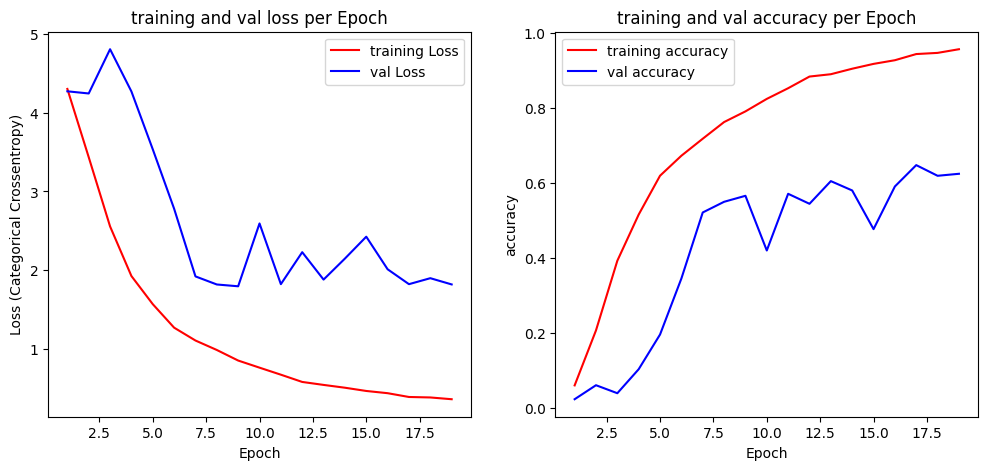

Model saved: HCRModel.keras


In [ ]:
recognizer = HCR(
    image_size=IMAGE_SIZE,
    model_path=MODEL_PATH,
    epochs=EPOCHS,
    history_path=HISTORY_PATH
)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Model Loaded")
else:
    train_ds, val_ds = load_data()
    num_classes = len(CLASS_NAMES)
    model = recognizer.build_model(num_classes)
    recognizer.train(model, train_ds, val_ds)
    recognizer.plot_history()
    print(f"Model saved: {MODEL_PATH}")